## Compare similarity of designed GFP and beta-lactamse sequences with low-N training mutants and evotuning sequences.

Creates plots that are panels within Supp Figs 8 and 12.

In [1]:
!pip install --upgrade pip
!pip install scipy==1.4.1

DEPRECATION: Python 3.5 reached the end of its life on September 13th, 2020. Please upgrade your Python as Python 3.5 is no longer maintained. pip 21.0 will drop support for Python 3.5 in January 2021. pip 21.0 will remove support for this functionality.
  Using cached pip-20.3.4-py2.py3-none-any.whl (1.5 MB)
  Using cached pip-20.3.3-py2.py3-none-any.whl (1.5 MB)
DEPRECATION: Python 3.5 reached the end of its life on September 13th, 2020. Please upgrade your Python as Python 3.5 is no longer maintained. pip 21.0 will drop support for Python 3.5 in January 2021. pip 21.0 will remove support for this functionality.


In [2]:
import os
import sys
import pickle
import random
import copy
import collections
import glob

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib as mpl
import tensorflow as tf
import seaborn as sns

from scipy.stats import spearmanr
from scipy.stats import ks_2samp

sys.path.append('../common')
import data_io_utils
import paths
import constants
import utils
import plot_style_utils

sys.path.append('../A008_analyze_chip_1/')
import A008_common

sys.path.append('../A006_simulated_annealing/')
import A006_common


%reload_ext autoreload
%autoreload 2

In [3]:
def read_simple_seq_file(seq_file):
    with open(seq_file) as f:
        rseqs = f.read().splitlines()
        
    return rseqs

def fasta_write(seqs, headers, file):
    with open(file, 'w') as f:
        for i in range(len(seqs)):
            f.write('>' + headers[i] + '\n')
            f.write(seqs[i] + '\n')

In [4]:
def create_mafft_input_fasta(seq_file, wt_seq, max_dissimilarity=0.3):
    # change max_dissimilarity to 1 to keep all sequences as partitioned in the
    # ablation sets.
    
    seqs = read_simple_seq_file(seq_file)
    headers = ['ET_close_seq_' + str(i) for i in range(len(seqs))]

    seqs = [wt_seq] + seqs # add wt
    headers = ['WT'] + headers # add wt
    
    max_mut = int(max_dissimilarity*len(wt_seq))
    ld = utils.levenshtein_distance_matrix([wt_seq], seqs).reshape(-1)
    to_keep = ld <= max_mut
    seqs = list(np.array(seqs)[to_keep])
    
    print('Max nmut:', max_mut)
    print('N seqs kept:', len(seqs))
    
    outfile = seq_file.replace('.txt', '_for_MSA.fasta')
    fasta_write(seqs, headers, outfile)

In [5]:
create_mafft_input_fasta('et_ablation_seq_sets/GFP_ET1_seqs_far_ablated.txt', constants.AVGFP_AA_SEQ)
create_mafft_input_fasta('et_ablation_seq_sets/GFP_ET2_seqs_far_ablated.txt', constants.AVGFP_AA_SEQ)
create_mafft_input_fasta('et_ablation_seq_sets/BLAC_ET_seqs_far_ablated.txt', constants.BETA_LAC_AA_SEQ)

Max nmut: 71
N seqs kept: 139
Max nmut: 71
N seqs kept: 36
Max nmut: 85
N seqs kept: 880


## Run MAFFT v7.471 (2020/Jul/3)

Outside of the notebook run mafft to align the sequences. For ease we'll do this outside of the docker environment.

Commands:

`sudo sh -c 'mafft --auto GFP_ET1_seqs_far_ablated_for_MSA.fasta > GFP_ET1_seqs_far_ablated_for_MSA_aln.fasta'`

`sudo sh -c 'mafft --auto GFP_ET2_seqs_far_ablated_for_MSA.fasta > GFP_ET2_seqs_far_ablated_for_MSA_aln.fasta'`

`sudo sh -c 'mafft --auto BLAC_ET_seqs_far_ablated_for_MSA.fasta > BLAC_ET_seqs_far_ablated_for_MSA_aln.fasta'`

In [6]:
PROT = 'GFP' # toggle
#PROT = 'BLAC' # toggle

In [7]:
if PROT == "BLAC":
    aln_seq_file = 'et_ablation_seq_sets/BLAC_ET_seqs_far_ablated_for_MSA_aln.fasta'
    wt_seq = constants.BETA_LAC_AA_SEQ
    prot = 'BLAC'
    QFUNC_COL = 'lfe_1000'
    
elif PROT == 'GFP':
    aln_seq_file = 'et_ablation_seq_sets/GFP_ET1_seqs_far_ablated_for_MSA_aln.fasta'
    wt_seq = constants.AVGFP_AA_SEQ
    prot = 'GFP'
    QFUNC_COL = 'qfunc'

In [8]:
def create_et_seq_matrix(et_aln_seq_file, wt_seq):
    headers, seqs = utils.fasta_read(et_aln_seq_file)

    assert len(np.unique([len(s) for s in seqs])) == 1

    aseqs = np.array([list(s) for s in seqs])
    
    assert headers[0] == 'WT'

    faseqs = aseqs[:,aseqs[0] != '-'] # remove gaps
    
    return faseqs

In [9]:
def get_s3_sim_anneal_pickle(seq_id, prot):
    splits = seq_id.split('-')
    
    fbasename = '-'.join(splits[:-1]) + '.p'
    
    if prot == 'BLAC':
        return os.path.join(data_io_utils.S3_DATA_ROOT, 
                'chip_1/simulated_annealing/beta_lactamase/' + fbasename)
    elif prot == 'GFP':
        return os.path.join(data_io_utils.S3_DATA_ROOT, 
                'chip_1/simulated_annealing/GFP/' + fbasename)

def load_protein_data(prot):
    if prot == 'BLAC':
        # Generated in mlpe-gfp-pilot repository
        lfe_data_file = os.path.join(data_io_utils.S3_DATA_ROOT, 'chip_1', 
                'A052e_BLAC_log_fold_enrichment.csv')
        data_io_utils.sync_s3_path_to_local(lfe_data_file, is_single_file=True)

        df = pd.read_csv(lfe_data_file)
        
    elif prot == 'GFP':
        inf_brightness_data_file = os.path.join(data_io_utils.S3_DATA_ROOT, 'chip_1', 
                'A052b_Chip_1_inferred_brightness_v2.csv')
        data_io_utils.sync_s3_path_to_local(inf_brightness_data_file, is_single_file=True)

        df = pd.read_csv(inf_brightness_data_file)

    q = df['id'].apply(lambda s: pd.Series(A008_common.split_seq_id_into_features(s)))
    df = df.merge(q, left_index=True, right_index=True)
    
    df['sa_pickle'] = df['id'].apply(lambda s: get_s3_sim_anneal_pickle(s, prot))

    display(df.head())
    print(df.columns)
    
    return df

In [10]:
def build_training_seq_matrix(sa_pickle):    
    with open(sa_pickle, 'rb') as f:
        sadata = pickle.load(f)
        
    train_seqs = list(sadata['train_df']['seq'])
    
    seq_matrix = np.array([list(s) for s in train_seqs])
    
    del sadata
    
    return seq_matrix

def build_and_save_all_training_matrices(df):

    sa_pickles = list(np.unique(df['sa_pickle']))

    for sap in sa_pickles:
        if sap[-3:] == '/.p':
            continue
        
        np_file = 'training_seq_matrices/'+os.path.basename(sap).replace('.p', '.npy')

        if not os.path.exists(np_file):    
            print(sap)

            # Grab the pickl containing everything related to a particular simulated annealing run
            data_io_utils.sync_s3_path_to_local(sap, is_single_file=True)

            # Build a numpy sequence matrix 
            training_smat = build_training_seq_matrix(sap)
            np.save(arr=training_smat, file=np_file)

            # Remove the pickle for storage purposes.
            os.remove(sap)

In [11]:
def get_pos(edit):
    return int(edit[1:-1])

def tabulate_mutations_in_seq_mat(seq_mat, wt_seq):
    edit_counts = {}
    pos_counts = {}
    for sv in seq_mat:
        seq = ''.join(list(sv))
        
        edits = utils.build_edit_string(seq, wt_seq)
        
        for e in edits:
            if e not in edit_counts:
                edit_counts[e] = 0
                
            if get_pos(e) not in pos_counts:
                pos_counts[get_pos(e)] = 0
                
            edit_counts[e] += 1
            pos_counts[get_pos(e)] += 1
            
    edit_df = pd.DataFrame(list(edit_counts.items()), columns=['unit', 'count'])
    pos_df = pd.DataFrame(list(pos_counts.items()), columns=['unit', 'count'])
        
    return edit_df, pos_df

In [12]:
def build_design_seq_mat(df, training_smat_npy):
    sa_run = os.path.basename(training_smat_npy).replace('.npy', '')
    
    mask = np.array(df['sa_pickle'].apply(lambda x: sa_run in x))
    df_sub = df[mask]
    #print(df_sub.shape)
    
    design_seqs = list(df_sub['seq'])
    
    design_seq_mat = np.array([list(s) for s in design_seqs])
    
    assert design_seq_mat.shape[0] == df_sub.shape[0]
    
    return design_seq_mat, df_sub

In [13]:
def characterize_variant_mutations(dseq, seq_mat, wt_seq):
    assert len(dseq) == seq_mat.shape[1]
    assert len(dseq) == len(wt_seq)

    num_shared = 0
    num_unique = 0
    for i in range(len(dseq)):
        if dseq[i] != wt_seq[i]:
            if dseq[i] in seq_mat[:,i]:
                num_shared += 1
            else:
                num_unique += 1

    ref_seqs = [''.join(s) for s in seq_mat] + [wt_seq]
    seq = ''.join(dseq)

    ld = utils.levenshtein_distance_matrix([seq], ref_seqs).reshape(-1)
    min_nmut = np.min(ld)

    return {
        'num_mut_shared': num_shared,
        'num_mut_unique': num_unique,
        'min_nmut_to_nearest': min_nmut
    }

def build_edit_and_pos_count_for_train_set_dfs(df, aln_seq_file, wt_seq, training_smat_npy, prot, 
        generate_per_variant_df=True):
    et_smat = create_et_seq_matrix(aln_seq_file, wt_seq) # only need to compute once.
    training_smat = np.load(training_smat_npy)
    design_smat, df_sub = build_design_seq_mat(df, training_smat_npy)
    
    if generate_per_variant_df:
        res = []
        design_training_mat = np.vstack([et_smat, training_smat])
        for dseq in design_smat:
            res.append(characterize_variant_mutations(dseq, design_training_mat, wt_seq))
        per_variant_df = pd.DataFrame(res)
        assert per_variant_df.shape[0] == df_sub.shape[0]
        per_variant_df['qfunc'] = np.array(df_sub[QFUNC_COL])
        per_variant_df['model'] = list(df_sub['model'])
        per_variant_df['rep'] = np.array(df_sub['rep'])
    else:
        per_variant_df = []
    
    et_edit_df, et_pos_df = tabulate_mutations_in_seq_mat(et_smat, wt_seq)
    train_edit_df, train_pos_df = tabulate_mutations_in_seq_mat(training_smat, wt_seq)
    design_edit_df, design_pos_df = tabulate_mutations_in_seq_mat(design_smat, wt_seq)
    
    edit_df = pd.merge(et_edit_df, train_edit_df, how='outer', on='unit').fillna(0)
    edit_df = pd.merge(edit_df, design_edit_df, how='outer', on='unit').fillna(0)
    edit_df.rename(columns={'count_x': 'count_et', 'count_y': 'count_train', 'count': 'count_design'}, inplace=True)

    pos_df = pd.merge(et_pos_df, train_pos_df, how='outer', on='unit').fillna(0)
    pos_df = pd.merge(pos_df, design_pos_df, how='outer', on='unit').fillna(0)
    pos_df.rename(columns={'count_x': 'count_et', 'count_y': 'count_train', 'count': 'count_design'}, inplace=True)
    
    # Limit only to positions mutated in our experiment to be completely fair.
    if prot == 'BLAC':
        min_pos = A006_common.BLAC_LIB_REGION[0] + 1 # 1 based, inclusive
        max_pos = A006_common.BLAC_LIB_REGION[1] + 1 # 1 based, exclusive
    elif prot == 'GFP':
        min_pos = A006_common.GFP_LIB_REGION[0] + 1 # 1 based, inclusive
        max_pos = A006_common.GFP_LIB_REGION[1] + 1 # 1 based, exclusive
    
    pos = np.array(edit_df['unit'].apply(get_pos))
    edit_df = edit_df[np.logical_and(pos >= min_pos, pos < max_pos) ] # [inclusive, exclusive)
    
    pos_df = pos_df[np.logical_and(pos_df['unit'] >= min_pos, pos_df['unit'] < max_pos)] # [inclusive, exclusive)
    
    return edit_df, pos_df, per_variant_df


def jaccard_sim(x,y):
    return np.sum(np.logical_and(x != 0, y !=0))/np.sum(np.logical_or(x != 0, y != 0))

def frac_captured(x, y):
    # Fraction of y captured by x.
    return np.sum(np.logical_and(x != 0, y !=0))/np.sum(y != 0)

def frac_uncaptured(ecounts, tcounts, dcounts):
    return np.sum(
        np.logical_and(np.logical_and(ecounts == 0, tcounts ==0), dcounts != 0)
    ) / len(dcounts)


def generate_summary_statistics_for_edit_and_pos_df(edit_df, pos_df): 
    summary = collections.OrderedDict()

    for s in ['_et', '_train']:
        summary['edit_jaccard_sim_to' + s] = jaccard_sim(edit_df['count' + s], edit_df['count_design'])
        summary['pos_jaccard_sim_to' + s] = jaccard_sim(pos_df['count' + s], pos_df['count_design'])

        summary['edit_frac_captured_by' + s] = frac_captured(edit_df['count' + s], edit_df['count_design'])
        summary['pos_frac_captured_by' + s] = frac_captured(pos_df['count' + s], pos_df['count_design'])

        summary['edit_spearman_to' + s] = spearmanr(edit_df['count' + s], edit_df['count_design'])[0]
        summary['pos_spearman_to' + s] = spearmanr(pos_df['count' + s], pos_df['count_design'])[0]


    # Fraction of all mutations in the designs not found in the ET or training sets.
    summary['edit_frac_uncaptured_by_et_and_train'] = frac_uncaptured(
        edit_df['count_et'], edit_df['count_train'], edit_df['count_design'])
    summary['pos_frac_uncaptured_by_et_and_train'] = frac_uncaptured(
        pos_df['count_et'], pos_df['count_train'], pos_df['count_design'])
    
    return summary

def build_summary_statistic_dataframe(df, aln_seq_file, wt_seq, prot, keep_only=None):
    training_smat_npys = glob.glob('training_seq_matrices/' + prot + '*')

    summaries = []
    per_var_df = []
    for training_smat_npy in training_smat_npys:
        if keep_only is not None and keep_only not in training_smat_npy:
            continue
        
        #print(training_smat_npy)
        edit_df, pos_df, pvdf = build_edit_and_pos_count_for_train_set_dfs(
                df, aln_seq_file, wt_seq, training_smat_npy, prot)
        per_var_df.append(pvdf)
        
        summary = generate_summary_statistics_for_edit_and_pos_df(edit_df, pos_df)

        sa_run = os.path.basename(training_smat_npy).replace('.npy', '') + '-dummy'

        runinfo = A008_common.split_seq_id_into_features(sa_run)
        del runinfo['seq_traj_idx']

        summary.update(runinfo)

        summaries.append(summary)

    summary_df = pd.DataFrame(summaries)
    per_var_df = pd.concat(per_var_df)
    
    return summary_df, per_var_df

def generate_summary_statistic_plot(summary_df, statistic, ylim=[0,1]):
    model_name_swap = {
        'OneHot': 'Full AA',
        'ET_Random_Init_1': 'Local\nUniRep',
        'ET_Global_Init_1': 'eUniRep 1',
        'ET_Global_Init_2': 'eUniRep 2'
    }
    
    # Ignore special cases to keep comparisons fair. E.g. SmallTrust for GFP
    # and LargeMut for BLAC. 
    summary_df = copy.deepcopy(summary_df)
    summary_df = summary_df[summary_df['special_case'] == '']
    nan_mask = np.isnan(summary_df['pos_spearman_to_train'])
    summary_df = summary_df[~nan_mask]

    if prot == 'GFP':
        x_order = ['OneHot', 'ET_Random_Init_1', 'ET_Global_Init_1', 'ET_Global_Init_2']
    elif prot == 'BLAC':
        x_order = ['OneHot', 'ET_Random_Init_1', 'ET_Global_Init_1']
        model_name_swap['ET_Global_Init_1'] = 'eUniRep'
        
    olen = len(x_order)
    mlist = list(np.unique(summary_df['model']))
    x_order = [x for x in x_order if x in mlist]

    fig = plt.figure(figsize=(10*len(x_order)/olen,5))
    ax = sns.stripplot(x="model", y=statistic, hue="ntrain",
                       data=summary_df, palette=plot_style_utils.CAT_PALETTE, dodge=True, linewidth=1,
                       order=x_order, size=10
                    )
    ax = sns.boxplot(x="model", y=statistic, hue="ntrain",
                        data=summary_df, palette=plot_style_utils.CAT_PALETTE, dodge=True, linewidth=1, whis=np.inf,
                        order=x_order, width=0.8
                    )

    for patch in ax.artists:
        r, g, b, a = patch.get_facecolor()
        patch.set_facecolor((r, g, b, .3))

    # Get the handles and labels. For this example it'll be 2 tuples
    # of length 4 each.
    handles, labels = ax.get_legend_handles_labels()

    # When creating the legend, only use the first two elements
    # to effectively remove the last two.
    l = plt.legend(handles[0:2], labels[0:2], bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)

    plt.gca().set_xticklabels([model_name_swap[s.get_text()] for s in plt.gca().get_xticklabels()])
    plt.xlabel('')
    
    if statistic == 'edit_frac_uncaptured_by_et_and_train':
        plt.ylabel('Fraction of mutations not found in evotuning\nor low-N training set sequences')
        v = plt.axis()
        plt.axis(list(v[:2]) + ylim)
    elif statistic == 'edit_spearman_to_et':
        plt.ylabel('Spearman corr. between mutation abundances\nin evotuning set and designed sequences')

    plt.grid('on')

    plt.show()
    return fig
    
def filter_for_gt_wt_for_eunirep(df, prot):
    if prot == 'BLAC':
        wt_idx = np.argwhere(df['seq'] == constants.BETA_LAC_AA_SEQ).reshape(-1)[0]
        eunirep_mask = df['model'] == 'ET_Global_Init_1'
    elif prot == 'GFP':
        wt_idx = np.argwhere(df['seq'] == constants.AVGFP_AA_SEQ).reshape(-1)[0]
        eunirep_mask = np.logical_or(df['model'] == 'ET_Global_Init_1',
                df['model'] == 'ET_Global_Init_2')
                                     
        
    wt_qfunc = df[QFUNC_COL].iloc[wt_idx]
    
    return df[np.logical_and(df[QFUNC_COL] > wt_qfunc, eunirep_mask)]
    
    

In [14]:
df = load_protein_data(prot)
df_wt = filter_for_gt_wt_for_eunirep(df, prot)
build_and_save_all_training_matrices(df)

,id,qfunc,qfunc_rep1,qfunc_rep2,extracted_lib_nt_seq,seq_idx,trajectory_idx,predicted_fitness,ensemble_predicted_fitness,seq,...,DE_Chip_1_GFP_NGS_16,DE_Chip_1_GFP_NGS_17,DE_Chip_1_GFP_NGS_18,model,ntrain,rep,rep_hash,seq_traj_idx,special_case,sa_pickle
0,GFP_SimAnneal-ET_Global_Init_2-0024-04-36079a2...,2.205245,2.335832,2.205245,AAAACAGAGGGTCCTAGAGACGCAACTTATGGTAAAATGACGCCGA...,2719.0,1741.0,9.660326e+07,[-4.4425168e+00 -4.4221644e+00 -5.1892853e+00 ...,MSKGEELFTGVVPILVELDGDVNGHKFSVKTEGPRDATYGKMTPKF...,...,0.0,0.0,0.0,ET_Global_Init_2,24.0,4.0,36079a2c,seq_idx_2719_1741,,/notebooks/analysis/common/../../data/s3/chip_...
1,GFP_SimAnneal-OneHot-0024-04-4279eeb-seq_idx_2...,1.945739,2.011986,1.945739,AAAACAGAGGGTGAAGGTGACGCAACTTATGGTAAACTGAGCCTGA...,2601.0,1191.0,7.883185e-01,[0.73590547 0.76271843 0.77913585 0.75764891 0...,MSKGEELFTGVVPILVELDGDVNGHKFSVKTEGEGDATYGKLSLKF...,...,0.0,0.0,0.0,OneHot,24.0,4.0,4279eeb,seq_idx_2601_1191,,/notebooks/analysis/common/../../data/s3/chip_...
2,GFP_SimAnneal-ET_Random_Init_1-0024-04-1989c09...,2.079981,2.279340,2.079981,AAAATGGAGGGTGAAGGTAATCCTACTGGTGGTAAACTGATTCAGA...,454.0,2029.0,7.540600e-01,[0.7710203 0.7359552 0.6161216 0.77072877 0...,MSKGEELFTGVVPILVELDGDVNGHKFSVKMEGEGNPTGGKLIQKF...,...,0.0,0.0,0.0,ET_Random_Init_1,24.0,4.0,1989c098,seq_idx_454_2029,,/notebooks/analysis/common/../../data/s3/chip_...
3,GFP_SimAnneal-ET_Global_Init_1-0024-04-4502d3-...,2.180828,2.236717,2.180828,AAAGGCATAGGTGAAGGTGACGCAACTATGGGTAAACTGACGATTC...,1809.0,1276.0,7.377951e-01,[1.0700963 0.7323966 0.79640985 0.7426758 0...,MSKGEELFTGVVPILVELDGDVNGHKFSVKGIGEGDATMGKLTIRF...,...,0.0,0.0,0.0,ET_Global_Init_1,24.0,4.0,4502d3,seq_idx_1809_1276,,/notebooks/analysis/common/../../data/s3/chip_...
4,GFP_SimAnneal-ET_Global_Init_1-0024-04-4502d3-...,2.670093,2.670093,2.720217,AAAGGCCAAGGTGAAGGTGAAGCAACTTATGGTAAACTGACGCTGA...,317.0,3482.0,7.378049e-01,[0.9574555 0.7345054 0.7397466 0.7718942 0...,MSKGEELFTGVVPILVELDGDVNGHKFSVKGQGEGEATYGKLTLKF...,...,1.0,1.0,0.0,ET_Global_Init_1,24.0,4.0,4502d3,seq_idx_317_3482,,/notebooks/analysis/common/../../data/s3/chip_...


Index(['id', 'qfunc', 'qfunc_rep1', 'qfunc_rep2', 'extracted_lib_nt_seq',
       'seq_idx', 'trajectory_idx', 'predicted_fitness',
       'ensemble_predicted_fitness', 'seq', 'protein', 'pred_score',
       'lib_aa_seq', 'constant_where_expected', 'successfully_clones',
       'error_message', 'dna_to_order', 'ligated_gene',
       'ligated_gene_translated', 'n_mut_rel_wt', 'oligo_len',
       'DE_Chip_1_GFP_NGS_01', 'DE_Chip_1_GFP_NGS_02', 'DE_Chip_1_GFP_NGS_03',
       'DE_Chip_1_GFP_NGS_04', 'DE_Chip_1_GFP_NGS_05', 'DE_Chip_1_GFP_NGS_06',
       'DE_Chip_1_GFP_NGS_07', 'DE_Chip_1_GFP_NGS_08', 'DE_Chip_1_GFP_NGS_09',
       'DE_Chip_1_GFP_NGS_10', 'DE_Chip_1_GFP_NGS_11', 'DE_Chip_1_GFP_NGS_12',
       'DE_Chip_1_GFP_NGS_13', 'DE_Chip_1_GFP_NGS_14', 'DE_Chip_1_GFP_NGS_15',
       'DE_Chip_1_GFP_NGS_16', 'DE_Chip_1_GFP_NGS_17', 'DE_Chip_1_GFP_NGS_18',
       'model', 'ntrain', 'rep', 'rep_hash', 'seq_traj_idx', 'special_case',
       'sa_pickle'],
      dtype='object')


## Stack top low-N mutants onto respective training data & close ET variants - Added 1/6/2021

In [15]:
top_n_et_seqs = 30
top_n_seqs = 5

ntrain = 24
model = 'ET_Global_Init_1'
rep = 1

sub_mask = np.logical_and.reduce(
    (df['ntrain']==ntrain, df['model']==model, df['rep'] == rep))

df_sub = df[sub_mask].sort_values(QFUNC_COL, ascending=False)
print(df_sub.shape)

(300, 46)


In [16]:
assert len(np.unique(df_sub['sa_pickle'])) == 1

In [17]:
def sort_seq_mat_by_distance(seq_mat, wt_seq):
    wt_seq_arr = np.array(list(wt_seq))
    dists = np.array([np.sum(wt_seq_arr != seq_mat[i]) for i in range(seq_mat.shape[0])] )
    sidx = np.argsort(dists)
    return seq_mat[sidx]

In [18]:
training_mat = np.load('training_seq_matrices/' + 
        os.path.basename(df_sub['sa_pickle'].iloc[0]).replace('.p', '.npy'))
training_mat = sort_seq_mat_by_distance(training_mat, wt_seq)
print(training_mat.shape)

et_seq_mat = create_et_seq_matrix(aln_seq_file, wt_seq)[1:] # Exclude wt seq
et_seq_mat = sort_seq_mat_by_distance(et_seq_mat, wt_seq)
print(et_seq_mat.shape)

top_seq_mat = np.vstack([np.array(list(s)) for s in list(df_sub['seq'])[:top_n_seqs]])
print(top_seq_mat.shape)

(24, 238)
(138, 238)
(5, 238)


In [19]:
wt_seq_arr = np.array(list(wt_seq))
var_pos = []
for ts in top_seq_mat:
    var_pos += list(np.argwhere(ts != wt_seq_arr).reshape(-1))
    
var_pos = np.unique(var_pos)

In [20]:
agg_seq_mat = np.vstack([wt_seq_arr.reshape(1,-1), top_seq_mat, training_mat, et_seq_mat[:30]])[:,var_pos]

print(agg_seq_mat.shape)

(60, 12)


In [21]:
alphabet = constants.AA_ALPHABET_STANDARD_ORDER + '-'

enc_agg_seq_mat = []
for s in agg_seq_mat:
    enc_agg_seq_mat.append([alphabet.find(x) for x in s])
    
enc_agg_seq_mat = np.vstack(enc_agg_seq_mat).T

/usr/local/lib/python3.5/dist-packages/matplotlib/font_manager.py:1241: UserWarning: findfont: Font family ['courier'] not found. Falling back to DejaVu Sans.
  (prop.get_family(), self.defaultFamily[fontext]))


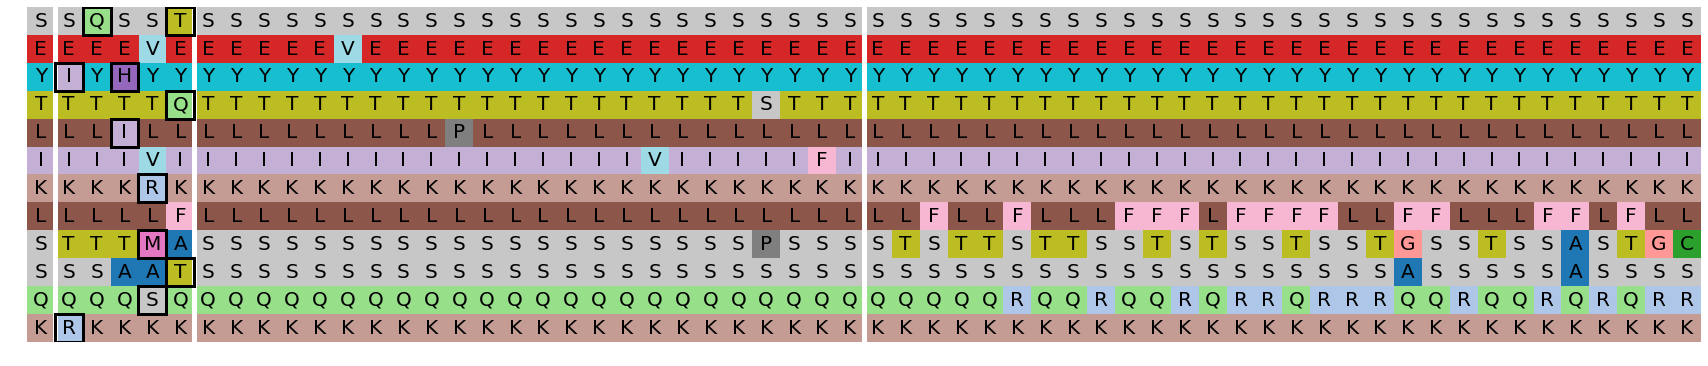

In [22]:
import matplotlib

def plot_box(i,j):
    b, l, h, w = j-0.5, i-0.5, 1, 1
    p = matplotlib.patches.Rectangle((b,l), w, h, 
            linewidth=3,edgecolor='k',facecolor='none',zorder=10)
    plt.gca().add_patch(p)
    
def add_chars_to_row(r, chars, fontsize=20):
    for i,c in enumerate(chars):
        plt.text(i,r,c, ha='center', va='center', fontsize=fontsize, fontname='courier')
    
def add_text_for_seq_mat(sm):
    for i,s in enumerate(sm):
        add_chars_to_row(i,list(s))

fig = plt.figure(figsize=(30,15))
plt.imshow(enc_agg_seq_mat, cmap='tab20')
plt.axvline(1-0.5, color='w', linewidth=5)
plt.axvline(1+top_n_seqs-0.5, color='w', linewidth=5)
plt.axvline(1+top_n_seqs+ntrain-0.5, color='w', linewidth=5)

train_et_sub = enc_agg_seq_mat[:, (1+top_n_seqs):]
for j in range(1,1+top_n_seqs): #+1 since WT is first.
    for i in range(enc_agg_seq_mat.shape[0]):
        char = enc_agg_seq_mat[i,j]
        
        if np.all(char != train_et_sub[i]):
            plot_box(i,j)
        

add_text_for_seq_mat(agg_seq_mat.T)

plt.axis('off')
plt.show()

fig_file = 'seq_stacks_wt_design_train_et_var_pos_only_%s_%s_%d_%d'%(PROT, model, ntrain, rep)
plot_style_utils.save_for_pub(fig, path='figures/'+fig_file)

### End of newly added code to plot sequence stacks

Code from before continues.

In [23]:
if not os.path.isfile('A014b_checkpoint_' + prot + '.p') or False:
    summary_df, per_variant_df = build_summary_statistic_dataframe(df, aln_seq_file, wt_seq, prot)
    summary_df_wt, per_variant_df_wt = build_summary_statistic_dataframe(df_wt, aln_seq_file, wt_seq, prot, keep_only='ET_Global_Init')
    
    with open('A014b_checkpoint_' + prot + '.p', 'wb') as f:
        pickle.dump(file=f, obj={
            'summary_df': summary_df,
            'per_variant_df': per_variant_df, 
            'summary_df_wt': summary_df_wt,
            'per_variant_df_wt': per_variant_df_wt
        })
else:
    print('Loading checkpoint')
    with open('A014b_checkpoint_' + prot + '.p', 'rb') as f:
        d = pickle.load(f)
        
    summary_df = d['summary_df']
    per_variant_df = d['per_variant_df']
    summary_df_wt = d['summary_df_wt']
    per_variant_df_wt = d['per_variant_df_wt']

Loading checkpoint


In [24]:
per_variant_df_wt.head()

,min_nmut_to_nearest,model,num_mut_shared,num_mut_unique,qfunc,rep
0,3.0,ET_Global_Init_2,2.0,1.0,3.469409,2.0
1,2.0,ET_Global_Init_2,1.0,1.0,3.466908,2.0
2,3.0,ET_Global_Init_2,1.0,2.0,3.718137,2.0
3,2.0,ET_Global_Init_2,1.0,1.0,3.553983,2.0
4,5.0,ET_Global_Init_2,3.0,2.0,3.847598,2.0


In [25]:
plot_style_utils.set_pub_plot_context()

/usr/local/lib/python3.5/dist-packages/matplotlib/cbook/__init__.py:424: MatplotlibDeprecationWarning: 
Passing one of 'on', 'true', 'off', 'false' as a boolean is deprecated; use an actual boolean (True/False) instead.
  warn_deprecated("2.2", "Passing one of 'on', 'true', 'off', 'false' as a "
/usr/local/lib/python3.5/dist-packages/matplotlib/font_manager.py:1241: UserWarning: findfont: Font family ['Helvetica'] not found. Falling back to DejaVu Sans.
  (prop.get_family(), self.defaultFamily[fontext]))


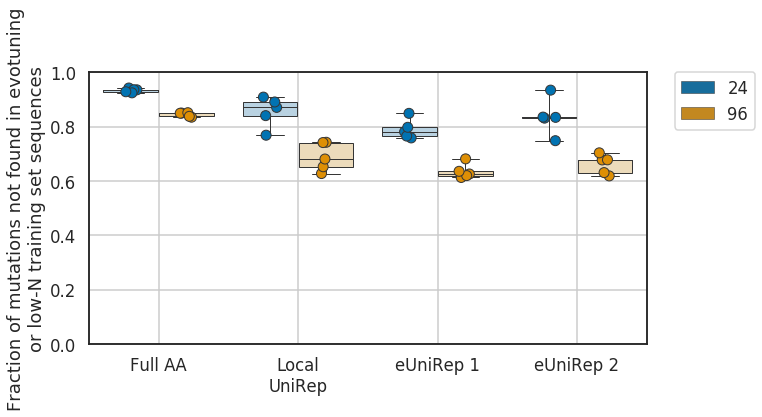

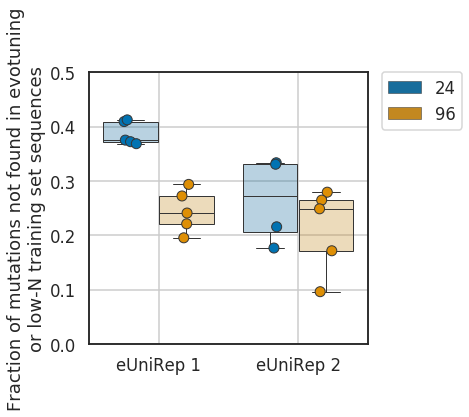

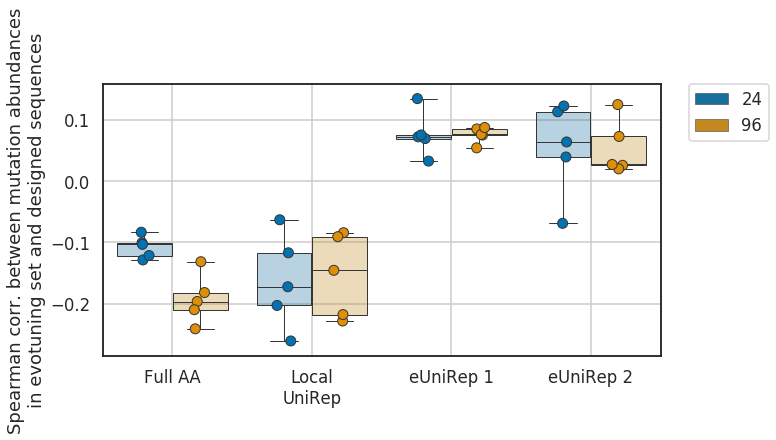

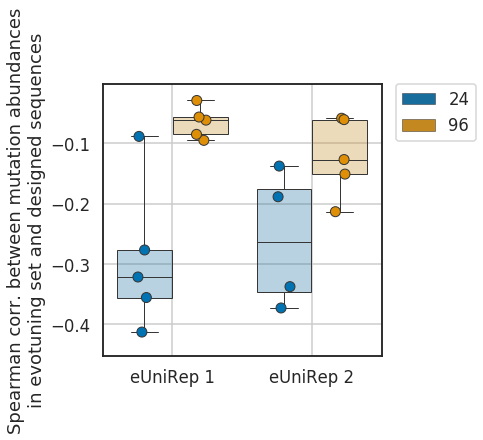

In [26]:
np.random.seed(42)
random.seed(42)

fig = generate_summary_statistic_plot(summary_df, 'edit_frac_uncaptured_by_et_and_train')
plot_style_utils.save_for_pub(fig=fig, path='figures/edit_frac_uncaptured_by_et_and_train_' + 'all_designs_' + prot)

fig = generate_summary_statistic_plot(summary_df_wt, 'edit_frac_uncaptured_by_et_and_train', ylim=[0, 0.5])
plot_style_utils.save_for_pub(fig=fig, path='figures/edit_frac_uncaptured_by_et_and_train_' + 'hfunc_designs_' + prot)

fig = generate_summary_statistic_plot(summary_df, 'edit_spearman_to_et')
plot_style_utils.save_for_pub(fig=fig, path='figures/edit_spearman_to_et' + 'all_designs_' + prot)

fig = generate_summary_statistic_plot(summary_df_wt, 'edit_spearman_to_et', ylim=[0, 0.5])
plot_style_utils.save_for_pub(fig=fig, path='figures/edit_spearman_to_et' + 'hfunc_designs_' + prot)


# Find unique eUniRep mutations with strong background averaged effect.

In [27]:
if prot == 'GFP':
    df[QFUNC_COL] = df[QFUNC_COL] - np.min(df[QFUNC_COL])
    WT_QFUNC = df[df['id'] == 'avGFP']['qfunc'].iloc[0]
elif prot == 'BLAC':
    WT_QFUNC = df[df['seq'] == constants.BETA_LAC_AA_SEQ][QFUNC_COL].iloc[0]

In [28]:
training_smat_npys = glob.glob('training_seq_matrices/' + prot + '*')
keep_only = 'ET_Global_Init'

edit_dfs = []
for training_smat_npy in training_smat_npys:
    if keep_only is not None and keep_only not in training_smat_npy:
        continue

    edit_df, _, _ = build_edit_and_pos_count_for_train_set_dfs(
            df_wt, aln_seq_file, wt_seq, training_smat_npy, prot, generate_per_variant_df=False)
    edit_dfs.append(edit_df)
    
master_edit_df = pd.concat(edit_dfs)

In [29]:
unique_mask = np.logical_and(master_edit_df['count_design'] != 0, 
        np.logical_and(master_edit_df['count_et'] == 0, master_edit_df['count_train'] == 0))
unique_edit_df = master_edit_df[unique_mask]
nonunique_edit_df = master_edit_df[~unique_mask]

unique_edits = np.unique(unique_edit_df['unit'])
nonunique_edits = np.unique(nonunique_edit_df['unit'])


print(unique_edit_df.shape)
print(nonunique_edit_df.shape)
print(len(unique_edits))
print(len(nonunique_edits))

print("frac unique:", len(unique_edits)/(len(unique_edits) + len(nonunique_edits)))

(989, 4)
(2669, 4)
255
259
frac unique: 0.4961089494163424


In [30]:
def edit_in_seq(seq, wt_seq, edit):
    pos = int(edit[1:-1])-1
    
    assert wt_seq[pos] == edit[0]
    
    return seq[pos] == edit[-1]
    
def get_seqs_and_qfuncs_with_edit(edit, df, wt_seq, return_raw=False):
    qfuncs = []
    seqs = []
    for i in range(df.shape[0]):
        s = df['seq'].iloc[i]
        if type(s) == str and edit_in_seq(s, wt_seq, edit):
            qfuncs.append(df[QFUNC_COL].iloc[i])
            seqs.append(s)
            
    summ_stat, pval = ks_2samp(qfuncs, df[QFUNC_COL], alternative='less')
            
    res = {
        'summary_stat': summ_stat,
        'pval': pval,
        'num_seqs': len(seqs)
    }
    
    if return_raw:
        res['qfunc_seqs_with_edit'] = qfuncs
            
    return res

In [31]:
unique_edit_res_df = []
for i,edit in enumerate(unique_edits):
    #print(i)
    res = get_seqs_and_qfuncs_with_edit(edit, df, wt_seq)
    res['edit'] = edit
    
    unique_edit_res_df.append(res)
    
unique_edit_res_df = pd.DataFrame(unique_edit_res_df)

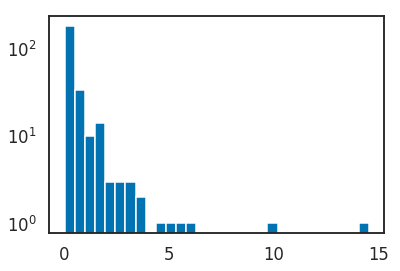

In [32]:
plt.hist(-np.log10(unique_edit_res_df['pval']), bins=30, color=plot_style_utils.CAT_PALETTE[0])
plt.yscale('log')
plt.show()

In [33]:
print(unique_edit_res_df.shape)
print(np.sum(unique_edit_res_df['pval'] < 0.05))
print(np.sum(unique_edit_res_df['pval'] < 0.05)/unique_edit_res_df.shape[0])

(255, 4)
35
0.13725490196078433


In [34]:
nlarge_df = unique_edit_res_df.nsmallest(3, 'pval').sort_values('pval')
nlarge_df

,edit,num_seqs,pval,summary_stat
225,T97M,311,2.767640e-15,0.234098
91,K101R,868,1.360204e-10,0.117601
144,N105Q,237,6.551124e-07,0.174022


/usr/local/lib/python3.5/dist-packages/matplotlib/axes/_axes.py:6521: MatplotlibDeprecationWarning: 
The 'normed' kwarg was deprecated in Matplotlib 2.1 and will be removed in 3.1. Use 'density' instead.
  alternative="'density'", removal="3.1")
/usr/local/lib/python3.5/dist-packages/matplotlib/cbook/__init__.py:424: MatplotlibDeprecationWarning: 
Passing one of 'on', 'true', 'off', 'false' as a boolean is deprecated; use an actual boolean (True/False) instead.
  warn_deprecated("2.2", "Passing one of 'on', 'true', 'off', 'false' as a "


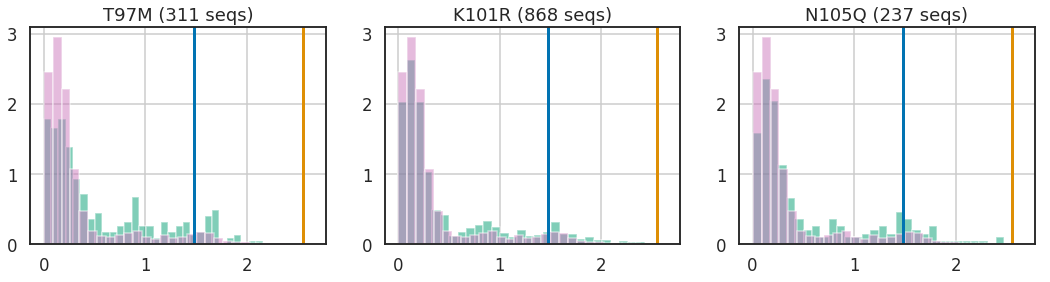

In [35]:
fig = plt.figure(figsize=(6*nlarge_df.shape[0],4))
for i in range(nlarge_df.shape[0]):
    edit = nlarge_df['edit'].iloc[i]
    res_special = get_seqs_and_qfuncs_with_edit(edit, df, wt_seq, return_raw=True)
    
    plt.subplot(1,nlarge_df.shape[0],i+1)
    plt.hist(res_special['qfunc_seqs_with_edit'], bins=30, normed=True, alpha=0.5, 
             color=plot_style_utils.CAT_PALETTE[2])
    plt.hist(df[QFUNC_COL], bins=30, normed=True, alpha=0.5, 
             color=plot_style_utils.CAT_PALETTE[4])
    
    plt.title(edit + ' (%d seqs)'%nlarge_df['num_seqs'].iloc[i])
    
    if prot == 'GFP':
        AVGFP_QFUNC = df[df['id'] == 'avGFP']['qfunc'].iloc[0]
        SFGFP_QFUNC = df[df['id'] == 'sfGFP']['qfunc'].iloc[0]
        plt.axvline(AVGFP_QFUNC, color=plot_style_utils.CAT_PALETTE[0], linewidth=3)
        plt.axvline(SFGFP_QFUNC, color=plot_style_utils.CAT_PALETTE[1], linewidth=3)
    if prot == 'BLAC':
        plt.axvline(WT_QFUNC, color=plot_style_utils.CAT_PALETTE[0], linewidth=3)
        
    plt.grid('on')
    
plt.show()

plot_style_utils.save_for_pub(fig=fig, path='figures/bg_avged_enriched_unique_mutants_' + prot )

## Look at how fraction of unique mutations correlates with quantitative function

In [36]:
per_variant_df.head()

,min_nmut_to_nearest,num_mut_shared,num_mut_unique,qfunc,model,rep
0,9.0,1,8,1.969042,ET_Random_Init_1,4.0
1,11.0,0,11,2.009121,ET_Random_Init_1,4.0
2,7.0,1,6,2.157112,ET_Random_Init_1,4.0
3,11.0,4,7,2.120423,ET_Random_Init_1,4.0
4,12.0,3,10,2.067962,ET_Random_Init_1,4.0


In [37]:
if prot == 'GFP':
    per_variant_df['qfunc'] += -np.min(per_variant_df['qfunc'])

per_variant_df['frac_mut_unique'] = (
    per_variant_df['num_mut_unique']/(per_variant_df['num_mut_unique'] + per_variant_df['num_mut_shared'])
)
per_variant_df['total_mut'] = (per_variant_df['num_mut_unique'] + per_variant_df['num_mut_shared']).astype(int)

In [38]:
sdf = per_variant_df[per_variant_df['model'] == 'ET_Global_Init_1']
sdf.head()

,min_nmut_to_nearest,num_mut_shared,num_mut_unique,qfunc,model,rep,frac_mut_unique,total_mut
0,11.0,4,7,0.246795,ET_Global_Init_1,2.0,0.636364,11
1,5.0,1,4,1.222820,ET_Global_Init_1,2.0,0.800000,5
2,13.0,5,8,0.465573,ET_Global_Init_1,2.0,0.615385,13
3,10.0,4,6,0.069724,ET_Global_Init_1,2.0,0.600000,10
4,11.0,4,7,0.448175,ET_Global_Init_1,2.0,0.636364,11


In [39]:
def calc_hit_rate_vs_frac_unique(qfuncs, frac_unique, wt_qfunc):
    nmuts = frac_unique
    unmuts, cts = np.unique(nmuts, return_counts=True)
    cts = cts[unmuts >= 0]
    unmuts = unmuts[unmuts >= 0]
    
    
    hr = np.array([np.sum(qfuncs[nmuts==n] > wt_qfunc)/len(qfuncs[nmuts==n]) for n in unmuts])
    
    hw = 1.96*np.sqrt(hr*(1-hr)/cts) # half width of 95% CI.
    
    
    sidx = np.argsort(unmuts)
    return unmuts[sidx], hr[sidx], hw[sidx]

/usr/local/lib/python3.5/dist-packages/matplotlib/cbook/__init__.py:424: MatplotlibDeprecationWarning: 
Passing one of 'on', 'true', 'off', 'false' as a boolean is deprecated; use an actual boolean (True/False) instead.
  warn_deprecated("2.2", "Passing one of 'on', 'true', 'off', 'false' as a "


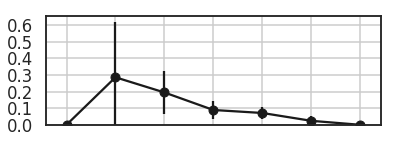

SpearmanrResult(correlation=-0.16586563118214767, pvalue=0.0001346048444911568)


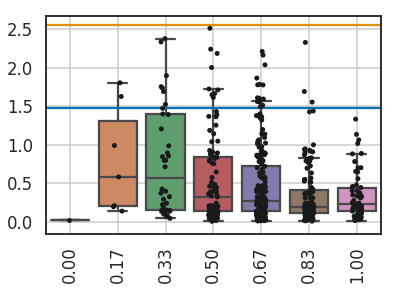

In [40]:
np.random.seed(42)
random.seed(42)

# Pick most common number of mutations
if prot == 'BLAC':
    TOTAL_MUT = 7
elif prot == 'GFP':
    TOTAL_MUT = 6
    
sub_sdf = sdf[sdf['total_mut'] == TOTAL_MUT]
min_frac = np.min(sub_sdf['frac_mut_unique'])


fig = plt.figure(figsize=(6,2))
fu, hr, hw = calc_hit_rate_vs_frac_unique(sub_sdf['qfunc'], sub_sdf['frac_mut_unique'], WT_QFUNC)
plt.errorbar(fu, hr, yerr=hw, fmt='-ok')

yl = plt.ylim()
plt.yticks([0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0])
plt.ylim(yl)
plt.ylim(bottom=0)
plt.xticks(np.arange(int(min_frac*TOTAL_MUT),TOTAL_MUT+1)/TOTAL_MUT)
plt.gca().set_xticklabels([])
plt.xlim([min_frac-0.07, 1+0.07])
plt.grid('on')
plt.show()

plot_style_utils.save_for_pub(fig=fig, path='figures/hit_rate_vs_frac_unique_mut_ET_Global_Init_1_' + prot)


fig = plt.figure()
sns.stripplot(x="frac_mut_unique", y="qfunc", data=sub_sdf, color='k')
sns.boxplot(x="frac_mut_unique", y="qfunc", data=sub_sdf, fliersize=0)
plt.xticks(rotation=90)
plt.gca().set_xticklabels(['%0.2f'%float(l._text) for l in plt.gca().get_xticklabels()])
plt.axhline(WT_QFUNC, color=plot_style_utils.CAT_PALETTE[0])
plt.xlabel('')
plt.ylabel('')

if prot == 'GFP':
    SFGFP_QFUNC = df[df['id'] == 'sfGFP']['qfunc'].iloc[0]
    plt.axhline(SFGFP_QFUNC, color=plot_style_utils.CAT_PALETTE[1])
print(spearmanr(sub_sdf['frac_mut_unique'], sub_sdf['qfunc']))
plt.grid('on')

plt.show()

plot_style_utils.save_for_pub(fig=fig, path='figures/strip_plot_frac_unique_mut_ET_Global_Init_1_' + prot)

In [41]:
print('FRACTION OF >WT DESIGNS WITH UNIQUE MUTATION - ' + prot)
sdf_wt = sdf[sdf['qfunc'] > WT_QFUNC]

print(np.sum(sdf_wt['frac_mut_unique']>0))
print(sdf_wt['frac_mut_unique'].shape[0])
print(np.sum(sdf_wt['frac_mut_unique']>0) / sdf_wt['frac_mut_unique'].shape[0])

FRACTION OF >WT DESIGNS WITH UNIQUE MUTATION - GFP
445
499
0.8917835671342685


In [42]:
for m in set(np.unique(per_variant_df['model'])) - set(['OneHot', 'ET_Random_Init_1']):
    print()
    print(m)
    sdf = per_variant_df[per_variant_df['model'] == m]
    for n in range(1,15):
        sub_sdf = sdf[sdf['total_mut'] == n]
        print(spearmanr(sub_sdf['frac_mut_unique'], sub_sdf['qfunc']))


ET_Global_Init_1
SpearmanrResult(correlation=-0.48393642563693384, pvalue=5.878630897463796e-07)
SpearmanrResult(correlation=-0.16095169846990548, pvalue=0.008295263017291344)
SpearmanrResult(correlation=-0.15311825962859701, pvalue=0.0016483275194239498)
SpearmanrResult(correlation=-0.1422418775470159, pvalue=0.003047006194560225)
SpearmanrResult(correlation=-0.1589543642529605, pvalue=0.00033575311748906567)
SpearmanrResult(correlation=-0.16586563118214767, pvalue=0.0001346048444911568)
SpearmanrResult(correlation=-0.08160041758416922, pvalue=0.06399716316876085)
SpearmanrResult(correlation=-0.03098932357413997, pvalue=0.6483287155096233)
SpearmanrResult(correlation=-0.09558643193734497, pvalue=0.16859147475140548)
SpearmanrResult(correlation=-0.13833771373664475, pvalue=0.0913655999270525)
SpearmanrResult(correlation=0.09660939566308385, pvalue=0.28579106629309553)
SpearmanrResult(correlation=-0.06805035282434506, pvalue=0.5435411859461027)
SpearmanrResult(correlation=-0.0786944512

### MAFFT Output for GFP ET1

```
outputhat23=2
treein = 0
compacttree = 0
stacksize: 8192 kb
rescale = 1
All-to-all alignment.
tbfast-pair (aa) Version 7.471
alg=L, model=BLOSUM62, 2.00, -0.10, +0.10, noshift, amax=0.0
0 thread(s)

outputhat23=2
Loading 'hat3.seed' ... 
done.
Writing hat3 for iterative refinement
rescale = 1
Gap Penalty = -1.53, +0.00, +0.00
tbutree = 1, compacttree = 0
Constructing a UPGMA tree ... 
  190 / 192
done.

Progressive alignment ... 
STEP   191 /191 
done.
tbfast (aa) Version 7.471
alg=A, model=BLOSUM62, 1.53, -0.00, -0.00, noshift, amax=0.0
1 thread(s)

minimumweight = 0.000010
autosubalignment = 0.000000
nthread = 0
randomseed = 0
blosum 62 / kimura 200
poffset = 0
niter = 2
sueff_global = 0.100000
nadd = 2
Loading 'hat3' ... done.
rescale = 1

  190 / 192
Segment   1/  1    1- 374
done 002-001-1  identical.   
dvtditr (aa) Version 7.471
alg=A, model=BLOSUM62, 1.53, -0.00, -0.00, noshift, amax=0.0
0 thread(s)


Strategy:
 L-INS-i (Probably most accurate, very slow)
 Iterative refinement method (<2) with LOCAL pairwise alignment information

If unsure which option to use, try 'mafft --auto input > output'.
For more information, see 'mafft --help', 'mafft --man' and the mafft page.

The default gap scoring scheme has been changed in version 7.110 (2013 Oct).
It tends to insert more gaps into gap-rich regions than previous versions.
To disable this change, add the --leavegappyregion option.
```

### Output for GFP ET2

```
outputhat23=16
treein = 0
compacttree = 0
stacksize: 8192 kb
rescale = 1
All-to-all alignment.
tbfast-pair (aa) Version 7.471
alg=L, model=BLOSUM62, 2.00, -0.10, +0.10, noshift, amax=0.0
0 thread(s)

outputhat23=16
Loading 'hat3.seed' ... 
done.
Writing hat3 for iterative refinement
rescale = 1
Gap Penalty = -1.53, +0.00, +0.00
tbutree = 1, compacttree = 0
Constructing a UPGMA tree ... 
   70 / 76
done.

Progressive alignment ... 
STEP    75 /75 
done.
tbfast (aa) Version 7.471
alg=A, model=BLOSUM62, 1.53, -0.00, -0.00, noshift, amax=0.0
1 thread(s)

minimumweight = 0.000010
autosubalignment = 0.000000
nthread = 0
randomseed = 0
blosum 62 / kimura 200
poffset = 0
niter = 16
sueff_global = 0.100000
nadd = 16
Loading 'hat3' ... done.
rescale = 1

   70 / 76
Segment   1/  1    1- 373
STEP 003-019-1  identical.   
Converged.

done
dvtditr (aa) Version 7.471
alg=A, model=BLOSUM62, 1.53, -0.00, -0.00, noshift, amax=0.0
0 thread(s)


Strategy:
 L-INS-i (Probably most accurate, very slow)
 Iterative refinement method (<16) with LOCAL pairwise alignment information

If unsure which option to use, try 'mafft --auto input > output'.
For more information, see 'mafft --help', 'mafft --man' and the mafft page.

The default gap scoring scheme has been changed in version 7.110 (2013 Oct).
It tends to insert more gaps into gap-rich regions than previous versions.
To disable this change, add the --leavegappyregion option.
```

### Output for BLAC ET

```
nthread = 0
nthreadpair = 0
nthreadtb = 0
ppenalty_ex = 0
stacksize: 8192 kb
rescale = 1
Gap Penalty = -1.53, +0.00, +0.00



Making a distance matrix ..
 8301 / 8355
done.

Constructing a UPGMA tree (efffree=0) ... 
 8350 / 8355
done.

Progressive alignment 1/2... 
STEP  3101 / 8354  f
Reallocating..done. *alloclen = 1704
STEP  8201 / 8354  f
Reallocating..done. *alloclen = 2772
STEP  8301 / 8354  h
done.

Making a distance matrix from msa.. 
 8300 / 8355
done.

Constructing a UPGMA tree (efffree=1) ... 
 8350 / 8355
done.

Progressive alignment 2/2... 
STEP  5101 / 8354  h
Reallocating..done. *alloclen = 1704
STEP  8301 / 8354  f
Reallocating..done. *alloclen = 2776

done.

disttbfast (aa) Version 7.471
alg=A, model=BLOSUM62, 1.53, -0.00, -0.00, noshift, amax=0.0
0 thread(s)


Strategy:
 FFT-NS-2 (Fast but rough)
 Progressive method (guide trees were built 2 times.)

If unsure which option to use, try 'mafft --auto input > output'.
For more information, see 'mafft --help', 'mafft --man' and the mafft page.

The default gap scoring scheme has been changed in version 7.110 (2013 Oct).
It tends to insert more gaps into gap-rich regions than previous versions.
To disable this change, add the --leavegappyregion option.
```